In [1]:
regenerate=False

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
import numpy as np

import camb
from camb import model, initialpower
import pandas as pd

plt.rcdefaults()

In [3]:
asymptote_sample_size = 10
snap_index = 0

In [4]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location(
    "spectra", "../shared/spectra.py")
spectra = importlib.util.module_from_spec(spec)
sys.modules["spectra"] = spectra
spec.loader.exec_module(spectra)

In [5]:
# Would it be more helpful to create a logspace?
onh2s = np.linspace(0, 0.01, 100)
onh2_strs = [str(np.around(onh2e, 4)) for onh2e in onh2s]

In [6]:
spec_sims = None

if regenerate:
    # It's a waste of time to consider all of the omegas and snapshots, so we're
    # making heavy use of skips.
    spec_sims = spectra.better_battery(onh2s, onh2_strs,
        skips_omega=[], skips_model=[8], skips_snapshot=[1, 2, 3], h_units=False)
    np.save("spec_sims.npy", spec_sims, allow_pickle=True)
else:
    # .item() is a little strange, but it allows me to recover a Python object
    # from a NumPy saving routine.
    spec_sims = np.load("spec_sims.npy", allow_pickle=True).item()

In [7]:
#data = spec_sims[onh2_str]
#data = spectra.powernu3[onh2_str]
#dTitle = "Lukas"
#dTitle = "Ariel III"

demo_index = 5
onh2_str = onh2_strs[demo_index]
data = spec_sims[onh2_str]
dTitle = "Space " + str(demo_index) + "th"
onh2 = onh2s[demo_index]

fig, axs = plt.subplots()
spectra.model_ratios_true(
    4, spec_sims[onh2_str], axs, massive='x', skips=[7, 8], omnuh2_str=onh2_str,
    title="Simulation attempt");

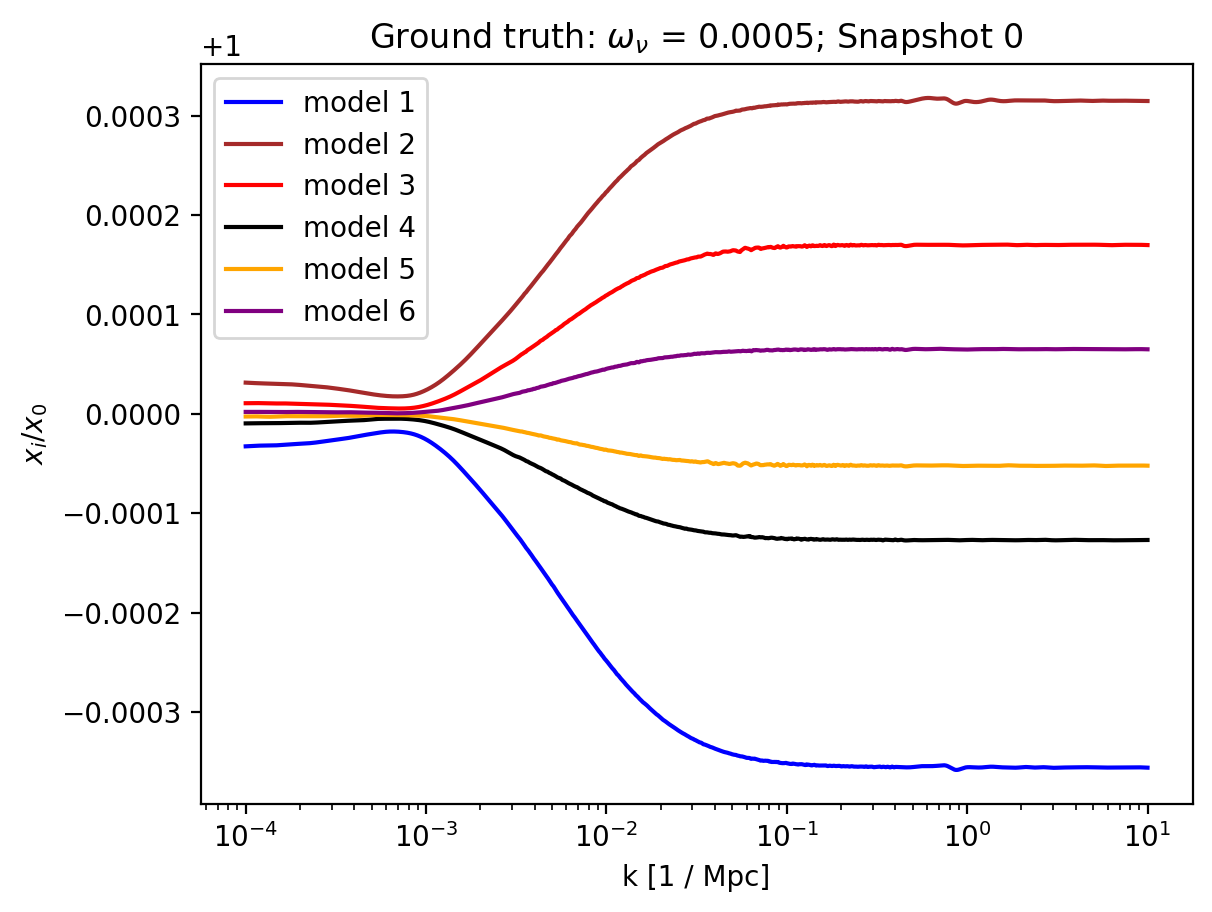

In [8]:
fig, axs = plt.subplots()
ks, rats = spectra.model_ratios_true(snap_index, data, axs,
    massive='x', skips=[7, 8], omnuh2_str=onh2_str);

In [9]:
# Be careful with the indexing here; rats[0] is the ratio of model 1 to model 0
#true_asymptotes = np.array([rats[i][len(rats[i]) - 1] for i in range(len(rats))])

true_asymptotes = []
for model_i in range(len(rats)):
    tail_start_idx = len(rats[model_i]) - asymptote_sample_size
    tail = rats[model_i][tail_start_idx:len(rats[model_i])]
    true_asymptotes.append(np.average(tail))
true_asymptotes = np.array(true_asymptotes)

zc_asymptotes = true_asymptotes - 1

In [10]:
true_asymptotes

array([0.99964386, 1.00031483, 1.00016985, 0.99987301, 0.9999478 ,
       1.00006494])

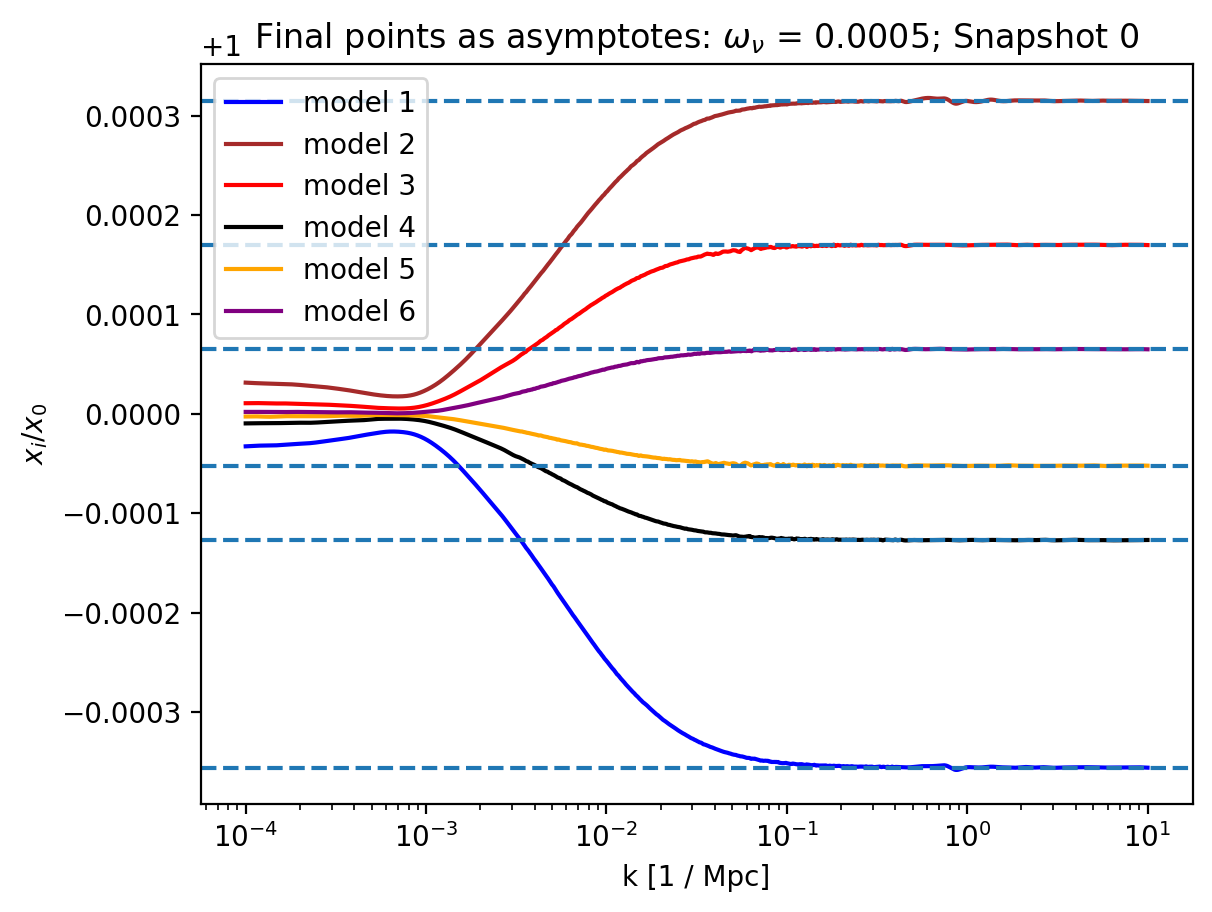

In [11]:
fig, axs = plt.subplots()
spectra.model_ratios_true(snap_index, data, axs,
    massive='x', skips=[7, 8], omnuh2_str=onh2_str,
    title="Final points as asymptotes")
for asymptote in true_asymptotes:
    axs.axhline(asymptote, linestyle='--')

y-intercept for this fit is 0.999998642561366
slope for this fit is 3.9919116261588754
Reduced chi squared value for this fit: 1.0566252329846352e-11


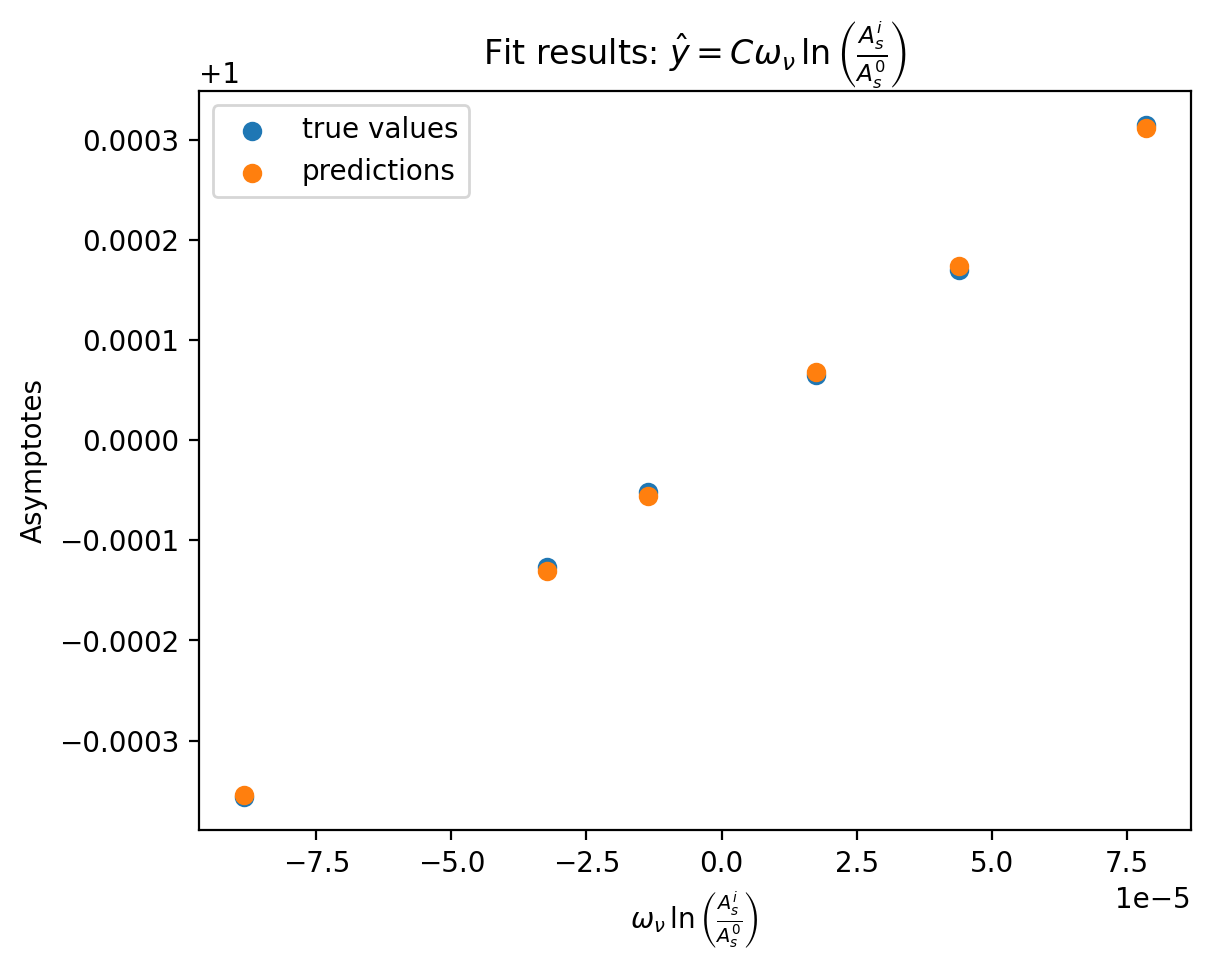

In [12]:
from numpy.polynomial.polynomial import polyfit
A_s = [spectra.cosm.loc[i]["A_s"] for i in range(7)]
x6 = onh2 * np.log(A_s[1:] / A_s[0])

model_desc_6 = r"\omega_\nu \, \ln \left( \frac{A_s^i}{A_s^0} \right)$"

plt.scatter(x6, true_asymptotes, label="true values")

b6, m6 = polyfit(x6, true_asymptotes, 1)

pred6 = m6 * x6 + b6
plt.scatter(x6, pred6, label="predictions")

print("y-intercept for this fit is", b6)
print("slope for this fit is", m6)

plt.ylabel("Asymptotes")
plt.xlabel("$" + model_desc_6)
plt.title(r"Fit results: $\hat{y} = C" + model_desc_6)
plt.legend()

chis6 = (true_asymptotes - pred6) ** 2 / pred6
red_chisq6 = sum(chis6) / len(x6)
print("Reduced chi squared value for this fit:", red_chisq6)

In [13]:
pred6

array([0.99964578, 1.00031193, 1.00017414, 0.99986979, 0.9999444 ,
       1.00006825])

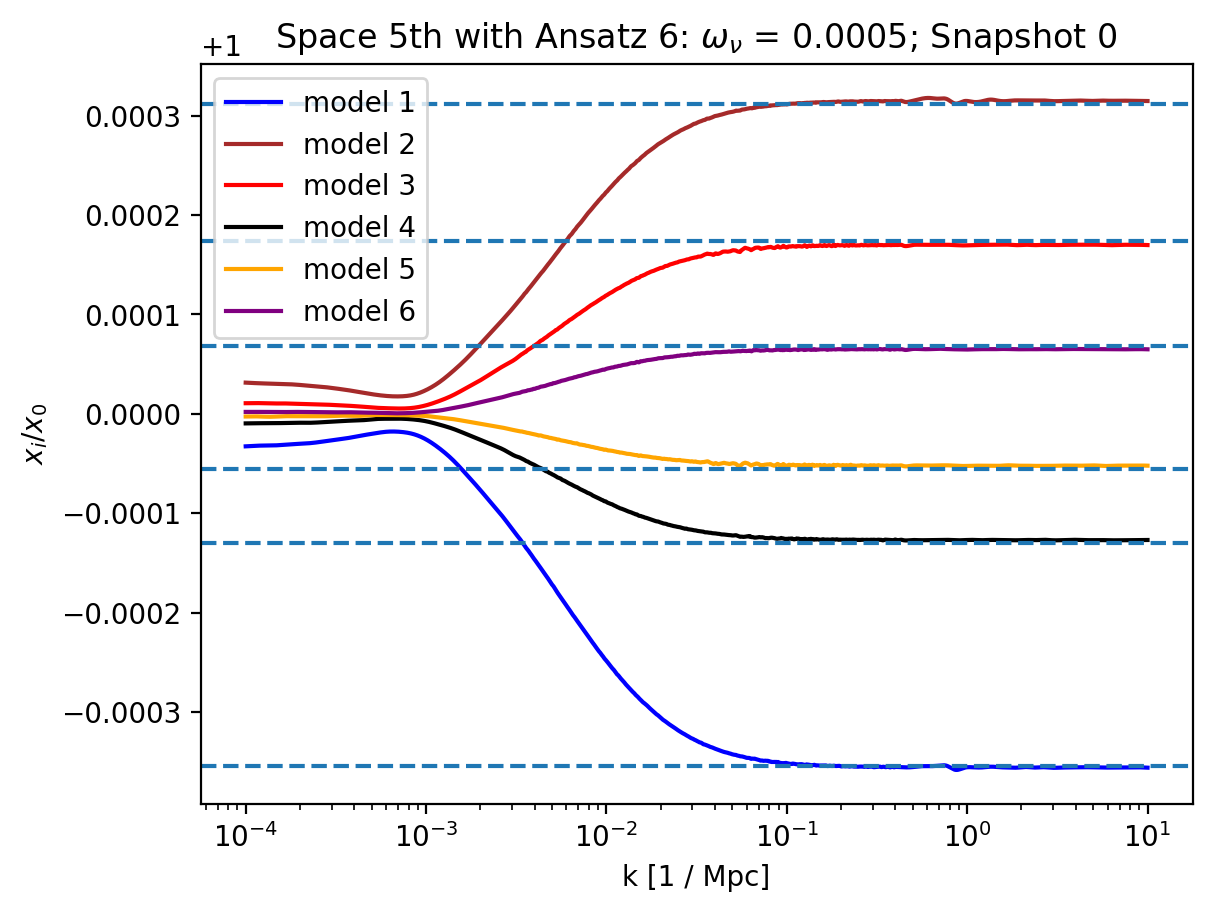

In [14]:
fig, axs = plt.subplots()
spectra.model_ratios_true(snap_index, data, axs,
    massive='x', skips=[7, 8], omnuh2_str=onh2_str,
    title=dTitle + " with Ansatz 6")
#axs.get_legend().remove()
for i in range(len(true_asymptotes)):
    axs.axhline(m6 * x6[i] + b6, linestyle='--')

In [15]:
chi_space = []
max_err_space = []
best_b = []
best_m = []

for i in range(len(spec_sims)):    
    data = spec_sims[onh2_strs[i]]
    dTitle = "Space " + str(i) + "th"
    ks, rats = spectra.model_ratios_true(snap_index, data, axs,
        massive='x', skips=[7, 8], omnuh2_str=onh2_str);
    true_asymptotes = np.array([rats[i][len(rats[i]) - 1] for i in range(len(rats))])
               
    x6 = onh2 * np.log(A_s[1:] / A_s[0])
    b6, m6 = polyfit(x6, true_asymptotes, 1)
    pred6 = m6 * x6 + b6
    best_b.append(b6)
    best_m.append(m6)
    
    errors = (true_asymptotes - pred6) / true_asymptotes * 100
    max_err_space.append(max(errors))           
               
    chisq6 = (true_asymptotes - pred6) ** 2 / pred6
    red_chisq6 = sum(chisq6) / len(x6)
    chi_space.append(red_chisq6)

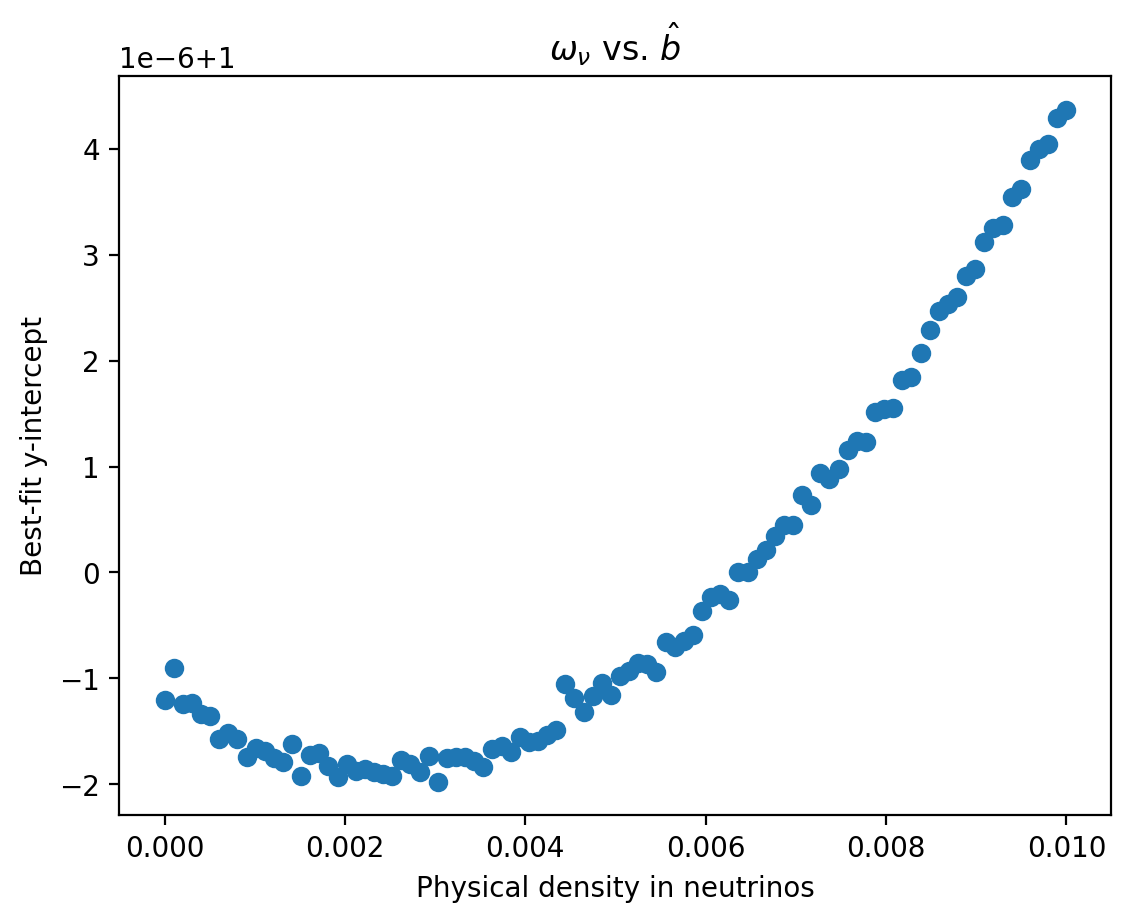

In [16]:
plt.title(r"$\omega_\nu$ vs. $\hat{b}$")
plt.ylabel("Best-fit y-intercept")
plt.xlabel("Physical density in neutrinos")
plt.scatter(onh2s, best_b)

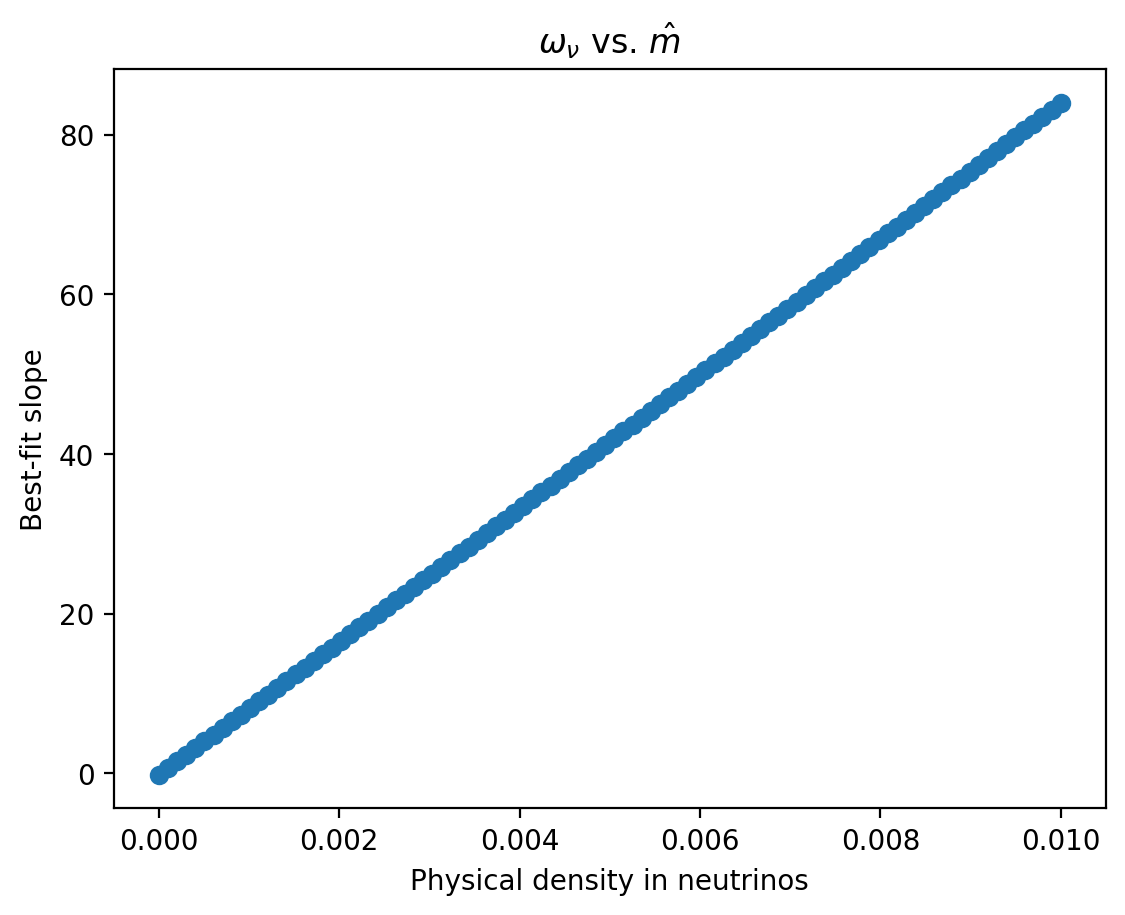

In [17]:
plt.title(r"$\omega_\nu$ vs. $\hat{m}$")
plt.ylabel("Best-fit slope")
plt.xlabel("Physical density in neutrinos")
plt.scatter(onh2s, best_m)

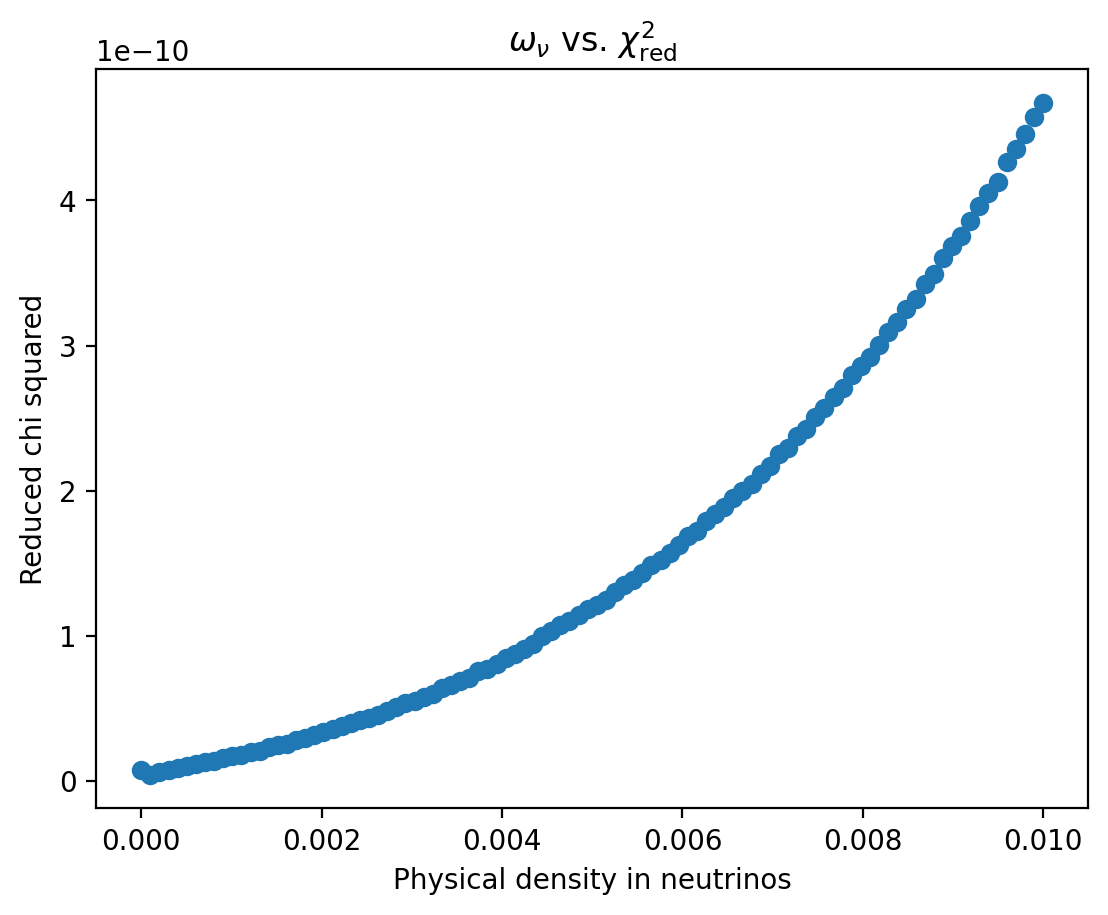

In [18]:
plt.title(r"$\omega_\nu$ vs. $\chi_\mathrm{red}^2$")
plt.ylabel("Reduced chi squared")
plt.xlabel("Physical density in neutrinos")
plt.scatter(onh2s, chi_space)

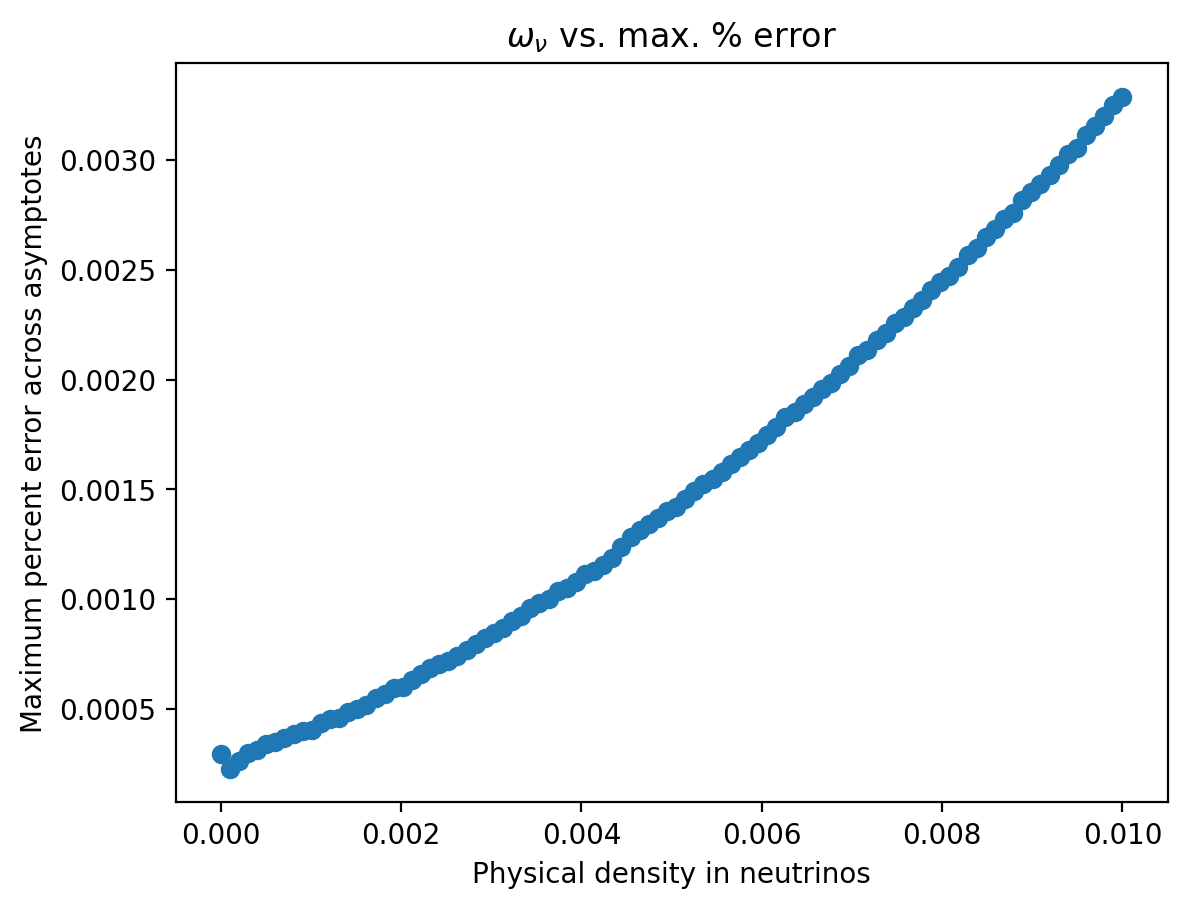

In [19]:
plt.title(r"$\omega_\nu$ vs. max. % error")
plt.ylabel("Maximum percent error across asymptotes")
plt.xlabel("Physical density in neutrinos")
plt.scatter(onh2s, max_err_space)